### 세팅

In [1]:
%matplotlib inline

from pathlib import Path
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.utils import resample

import seaborn as sns
import matplotlib.pylab as plt

In [2]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

In [3]:
LOANS_INCOME_CSV = DATA / 'loans_income.csv'
SP500_DATA_CSV = DATA / 'sp500_data.csv.gz'

### 임의표본 추출과 표본편향
- 임의표본추출(랜덤표본추출) : 무작위로 표본 추출
- 층화표본추출 : 모집단을 층으로 나눈 뒤, 각 층에서 무작위로 추출
- 계층(stratum) : 공통된 특징을 가진 모집단의 동종 하위 그룹
- 단순임의표본 : 모집단 층화 없이 임의표본 추출로 얻은 표본
- 편향(bias) : 계통상의 오류 (통계적 편향은 측정 과정 or 표본추출 과정에서 발생하는 계통적인systematic 오차를 의미한다.)
- 표본편향 (sample bias) : 모집단을 잘못 대표하는 표본
- 비임의(nonrandom) : 아무리 랜덤표본이라 해도, 어떤 표본도 모집단을 정확하게 대표할 수는 없다.

### 선택편향
- 선택편향은 데이터를 의식적이든 무의식적이든 선택적으로 고르는 관행을 의미한다. 결국 오해의 소지가 있거나 단편적인 결론을 얻게 된다.
- 선택편향 : 관측 데이터를 선택하는 방식 때문에 생기는 편향
- 방대한 검색 효과 (vast search effect) : 중복 데이터 모델링이나 너무 많은 예측 변수를 고려하는 모델링에서 비롯되는 편향 혹은 비재현성
- 성능을 검증하기 위해 둘 이상의 홀드아웃(Holdout)세트를 이용하면 방지할 수 있다.
- 또한 데이터 마이닝 모델에서 제시하는 예측들을 검증하기 위해 목표값 섞기(Target shuffling, 순열검정)을 추천했다.
- 평균으로 회귀(regression to the mean) : 어떤 변수를 연속적으로 측정했을 때 나타나는 현상. 예외 경우를 너무 특별히 생각하고 의미를 부여하면 선택편향으로 이어질 수 있다.
- 가설을 구체적으로 명시하고 임의표본추출 원칙에 따라 데이터를 수집하면 편향을 피할 수 있다.

### 표본분포
- 데이터 분포(data distribution) : 어떤 데이터 집합에서의 각 개별 값의 도수분포
- 표본분포(sampling distribution) : 여러 표본들 혹은 재표본들로부터 얻은 표본 통계량의 도수분포
- 중신 극한정리(central limit theorem) : 표본크기가 커질수록 표본분포가 정규분포를 따르는 경향
- 표준오차 (standard error) : 어떤 표본들로부터 얻은 표본통계량의 변량(개별 데이터 값들의 변량을 뜻하는 표준편차와 혼동하지 말것)
- 평균과 같은 표본 통계량의 분포는 데이터 자체의 분포보다 규칙적이고 종 모양일 가능성이 높다. 또한 표본이 클수록 표본통계량의 분포가 좁아진다.

In [4]:
loans_income = pd.read_csv(LOANS_INCOME_CSV).squeeze('columns')

sample_data = pd.DataFrame({
    'income': loans_income.sample(1000),
    'type': 'Data',
})

# 5개의 값의 편균으로 이뤄진 표본 하나
sample_mean_05 = pd.DataFrame({
    'income': [loans_income.sample(5).mean() for _ in range(1000)],
    'type': 'Mean of 5',
})

# 20개의 값의 평균으로 이뤄진 표본 하나
sample_mean_20 = pd.DataFrame({
    'income': [loans_income.sample(20).mean() for _ in range(1000)],
    'type': 'Mean of 20',
})

results = pd.concat([sample_data, sample_mean_05, sample_mean_20])
print(results.head())

         income  type
24101  105294.0  Data
37848   40000.0  Data
42901   80000.0  Data
28733   80000.0  Data
43165   76000.0  Data


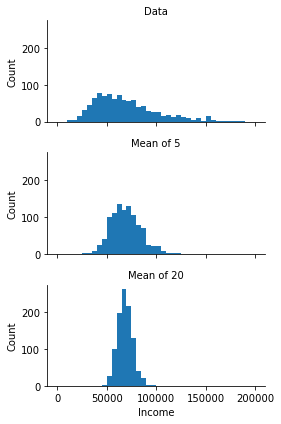

In [5]:
# 개별 데이터 값의 히스토그램은 넓게 분산되어 있고, 한쪽으로 기울어져 있다.
# 5와 20의 평균에 대한 히스토그램은 갈수록 좁고 벨 모양이 된다.

# 이를 [중심극한정리] 라고 한다. 
# 모집단이 정규분포가 아니더라도, 표본크기가 충분하고 데이터가 정규성을 크게 이탈하지 않는 경우, 여러표본에서 추출한 평균은 종모양의 정규곡선을 따른다.
# 중심극한정리 덕분에, 신뢰구간이나 가설검정을 계산하는데 t분포 같은 정규근사 공식을 사용할 수 있다.

g = sns.FacetGrid(results, col='type', col_wrap=1, 
                  height=2, aspect=2)
g.map(plt.hist, 'income', range=[0, 200000], bins=40)
g.set_axis_labels('Income', 'Count')
g.set_titles('{col_name}')

plt.tight_layout()
plt.show()

### 표준오차
- 표준오차는 통계에 대한 표본분포의 변동성을 한마디로 말해주는 단일 측정 지표이다.
- 표본크기가 커지면 표준오차는 작아진다. 표준오차와 표본크기 사이의 관계를 때로는 n 제곱근의 법칙이라고 한다.(표준오차를 2배 줄이려면, 표본크기를 4배 증가시켜야한다.)
- 표준오차를 측정할 때 고려사항
1. 모집단에서 완전히 새로운 샘플들을 많이 수집
2. 각각의 새 샘플에 대해 통계량(예:평균)을 계산한다.
3. 2단계에서 얻은 통계량의 표준편차를 계산한다. 이것을 표준오차의 추정치로 사용한다.
- 실질적으로 표준오차를 추정하기 위해 새 샘플을 수집하는 접근 방식은 일반적으로 불가능하다.(통계적으로도 낭비가 심함)
- 새로운 표본을 뽑는 대신 부트스트랩 재표본을 사용할 수 있다.

### 부트스트랩(Bootstrap) - 복원추출
- 부트스트랩 : 통계량이나 모수의 표본분포를 추정하는 쉽고 효과적인 방법, 현재 있는 표본에서 추가적으로 표본을 복원추출하고 각 표본에 대한 통계량과 모델을 다시 계산하는 절차
- 부트스트랩 표본(bootstrap sample) : 관측 데이터 집합으로부터 얻은 복원추출 표본
- 재표본추출(재표집,리샘플링resampling) : 관측 데이터로부터 반복해서 표본추출하는 과정, 부트스트랩과 순열(셔플링) 과정을 포함한다.
- 반복 횟수가 많을수록 표준오차나 신뢰구간에 대한 추정이 명확해진다.
- 부트스트랩은 표본크기가 작은 것을 보완하기 위한 것이 아니다. 새 데이터를 만드는것도 아니며, 기존 데이터 집합의 빈곳을 채우는 것도 아니다.
- 모집단에서 추가적으로 표본을 뽑는다고 할 때, 그 표본이 얼마나 원래 표본과 비슷할지를 알려줄 뿐이다.

### 재표본추출 대 부트스트래핑
- 재표본추출 : 여러 표본이 결합되어 비복원추출을 수행할 수 있는 순열 과정을 포함한다.
- 부트스트랩 : 항상 관측된 데이터로부터 복원추출한다.

### 신뢰구간
- 신뢰수준(confidence level) : 같은 모집단으로부터 같은 방식으로 얻은, 관심 통계량을 포함할 것으로 예상되는 신뢰구간의 백분율. 신뢰수준이 높을 수록 구간이 더 넓어진다. 표본이 작을수록 구간이 넓어진다(즉, 불확실성이 더 커진다.)
- 구간끝점(interval endpoint) : 신뢰구간의 최상위, 최하위 끝점
- 신뢰구간은 구간 범위로 추정값을 표시하는 일반적인 방법이다.
- 더 많은 데이터를 보유할 수록 표본추정치의 변이가 줄어든다.
- 부트스트랩은 신뢰구간을 구성하는 효과적인 방법이다.

### 정규분포
- 오차(error) : 데이터 포인트와 예측값 혹은 평균 사이의 차이
- 표준화(정규화,standardize) : 평균을 빼고 표준편차로 나눈다.
- z-score : 개별 데이터 포인트를 정규화한 결과
- 표준정규분포(standard normal distribution) : 평균=0, 표준편차=1인 정규분포
- QQ그림 : 표본분포가 특정분포(예:정규분포)에 얼마나 가까운지를 보여주는 그림. z점수를 오름차순으로 정렬하고 각 값의 z점수를 y축에 표시한다. x축은 정규분포에서 해당 분위수를 나타낸다. 데이터가 표준화 되었기 때문에, 단위는 평균으로부터 떨어진 데이터의 표준편차 수에 해당한다.

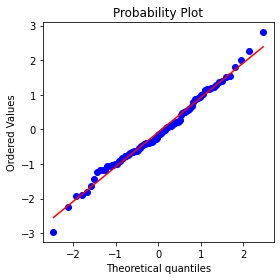

In [6]:
fig, ax = plt.subplots(figsize=(4, 4))

norm_sample = stats.norm.rvs(size=100)
stats.probplot(norm_sample, plot=ax)

plt.tight_layout()
plt.show()

### 긴 꼬리 분포
- 꼬리(tail) : 적은 수의 극단값이 주로 존재하는 도수분포의 길고 좁은 부분
- 왜도(skewness) : 분포의 한쪽 꼬리가 반대쪽 다른 꼬리보다 긴 정도
- 때로 분포가 소득 데이터와 같이 비스틈하게 기울어져 있거나 이항 데이터같이 이산적일 수 있다. 대칭 및 비대칭 분포 모두 긴꼬리(long tail)을 가질 수 있다. 분포의 꼬리는 양극한 값에 해당한다.

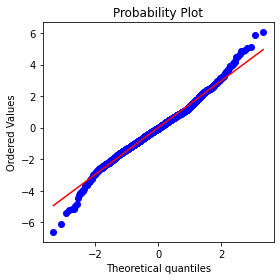

In [7]:
# 낮은 값의 점들은 대각선보다 낮고, 높은 값은 선보다 위에 위치한다.
# 이는 데이터가 정규분포를 따르지 않는다는 것을 의미한다.
# 또한 이는 데이터가 정규분포를 따른다고 할 때 예상되는 것보다 훨씬 더 많은 극단값을 관찰할 가능성이 있음을 의미한다.
# 평균에서 표준편차 이내에 있는 데이터의 점들은 선에 가까이 있다.
sp500_px = pd.read_csv(SP500_DATA_CSV)

nflx = sp500_px.NFLX
nflx = np.diff(np.log(nflx[nflx>0]))

fig, ax = plt.subplots(figsize=(4, 4))
stats.probplot(nflx, plot=ax)

plt.tight_layout()
plt.show()

### 스튜던트의 t 분포
- t분포는 정규분포와 생김새가 비슷하지만, 꼬리 부분이 약간 더 두껍고 길다. 표본이 클수록 더 정규분포를 닮은 t분포가 형성된다.
- 자유도(degrees of freedom) : 다른 표본크기,통계량, 그룹의 수에 따라 t분포를 조절하는 변수
- x축에 표준화된 결과(z-score), y축에 빈도를 나타내는 도표
- t분포는 정규분포와 비슷한데 꼬리만 조금 더 두꺼운 형태이다. > 분포가 작다.
- t분포는 표본평균, 두 표본평균 사이의 차이, 회귀 파라미터 등의 분포를 위한 기준으로 사용된다.

### 이항분포
- 시행(trial) : 독립된 결과를 가져오는 하나의 사건(예: 동전 던지기)
- 성공 : 시행에 대한 관심의 결과
- 이항식(binomial) : 두가지 결과를 갖는다.(이진)
- 이항시행(binomial trial) : 두가지 결과를 가져오는 시행(베르누이 시행)
- 이항분포(binomial distribution) : n번 시행에서 성공한 횟수에 대한 분포(베르누이 분포)
- n : 시행횟수
- p : 성공 확률
- 보통 n번 시도에서 x번 또는 그 이하로 성공할 확률이 얼마일지 알아보는데 관심이 있다.
- 분산:np(1-p)
- 이항분포는 사실상 정규분포와 구별이 어렵다. n이 크고, p가 0또는1에 너무 가깝지 않은 경우, 이항분포는 정규분포로 근사할 수 있다.

### 카이제곱분포
- 카이제곱통계량은 검정 결과가 독립성에 대한 귀무 기댓값에서 벗어난 정도를 측정하는 통계량이다.
- 이것은 관측값과 기댓값의 차이를 기댓값의 제곱근으로 나눈 값을 다시 제곱하고 모든 범주에 대해 합산한 값이다.
- 일반적으로 카이제곱통계량은 관측 데이터가 특정 분포에 '적합'한 정도를 나타낸다.(적합도 검정)
- 카이제곱분포는 귀무 모델에서 반복적으로 재표본추출한 통계량 분포다.
- 카이제곱 값이 높은 것은 기대한 것과 현저하게 다르다는 것을 나타낸다.
- 카이제곱분포는 일반적으로 범주에 속하는 주제 또는 항목의 수와 관련있다.
- 카이제곱통계는 귀무 모델의 기댓값에서 벗어난 정도를 측정한다.

### F분포
- F통계량은 그룹 평균 간의 차이가 정규 무작위 변동에서 예상할 수 있는 것보다 얼마나 큰지를 측정한다. 각 그룹 내 변동성(잔차 변동성)에 대한 그룹 평균 간 변동성의 비율을 의미한다. 이러한 비교를 [분산분석](analysis of variance)라고 한다.ANOVA
- F 통계량의 분포는 모든 그룹의 평균이 동일한 경우(귀무 모델), 무작위 순열 데이터에 의해 생성되는 모든 값의 빈도 분포다. 서로 다른 자유도에 따라 다양한 F분포가 있다.
- F분포는 측정된 데이터와 관련한 실험 및 선형 모델에 사용
- F통계량은 관심요인으로 인한 변동성과 전체 변동성을 비교한다.

### 푸아송 분포와 지수분포, 베이불 분포
- 람다(Lambda) : 단위 시간이나 단위 면적당 사건이 발생하는 비율
- 푸아송 분포(Poisson distribution) : 표집된 단위 시간 혹은 단위 공간에서 발생한 사건의 도수분포
- 지수분포(exponential distribution) : 한 사건에서 그다음 사건까지의 시간이나 거리에 대한 도수분포
- 베이불 분포(Weibull distribution) : 사건 발생률이 시간에 따라 변화하는, 지수분포의 일반화된 버전
- 푸아송이나 지수분포에 대한 시뮬레이션 연구에서 핵심은 람다가 해당 기간 동안 일정하게 유지 된다는 가정이다.
- 일정 비율로 발생하는 사건의 경우, 시간 단위 또는 공간 단위당 발생하는 사건의 수를 푸아송 분포로 모델링 할 수 잇다.

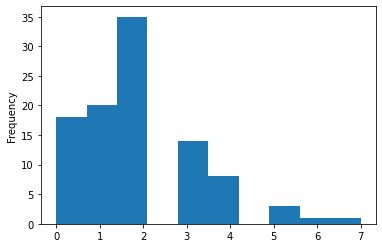

In [8]:
# 푸아송 분포
# 푸아송 분포 예 : 5초 동안 서버에 도착한 인터넷 트래픽을 95%의 확률로 완벽하게 처리하는 데 필요한 용량은 얼마일까? 같은 대기 행렬 관련 질문 처리에 용이
# 푸아송 분포의 핵심 파라미터는 람다 이다. 분산 역시 람다이다.

# 람다가 2인 푸아송 분포에서 난수 100개를 생성한다.
# 예로 고객 서비스 센터에 1분당 평균 2회로 문의 전화가 접수된다면, 이코드는 100분을 시뮬레이션하여 100분당 문의 전화 횟수를 알려준다.

sample = stats.poisson.rvs(2, size=100)

pd.Series(sample).plot.hist()
plt.show()

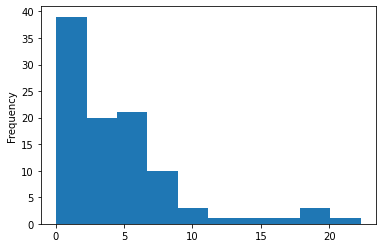

In [10]:
# 지수분포
# 푸아송 분포에 사용된 것과 동일한 변수 람다를 사용하여 사건과 사건 간의 시간 분포를 모델링 할 수 있다.

# 평균 사건 수가 0.2인 지수분포에서 난수 100개를 생성한다.
# 따라서 분당 평균적으로 0.2회 서비스 문의 전화가 걸려오는 경우, 100분 동안의 서비스 센터 문의 전화를 시뮬레이션 할 수 있다.
sample = stats.expon.rvs(scale=1/0.2, size=100)

pd.Series(sample).plot.hist()
plt.show()